# Analyzing FreeSurfer Data Using Neuropythy

This tutorial is an introduction to using Neuropythy to analyze FreeSurfer data. More information about FreeSurfer itself can be found [here](https://surfer.nmr.mgh.harvard.edu/). This tutorial is about using Neuropythy to examine and visualize the data produced by FreeSurfer, primarily its `recon-all` tool.

**Author**: &nbsp;&nbsp; [Noah C. Benson](mailto:nben@uw.edu)  
**Date**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; June 01, 2022  
**Link**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [noahbenson/neuropythy-tutorials](https://github.com/noahbenson/neuropythy-tutorials)

## Setup

To start with, we need to import various libraries. These include, first, neuropythy itself, and, second, the matplotlib/pyplot libraries for 2D plotting. We also import various utility libraries like os and sys.

Note that we setup some options for matplotlib in the cells following our library-import cell. This is due to bugs in previous versions of matplotlib/jupyter that caused problems when the configuration was set in the same cell as the import.

In [1]:
# Import some standard/utility libraries:
import os, sys, six # six provides python 2/3 compatibility

# Import our numerical/scientific libraries, scipy and numpy:
import numpy as np
import scipy as sp

# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt

# We also import ipyvolume, the 3D graphics library used by neurropythy, for 3D
# surface rendering (optional).
import ipyvolume as ipv

In [2]:
# These "magic commands" tell matplotlib that we want to plot figures inline and
# That we are using qt as a backend; due to bugs in certain versions of
# matplotlib, we put them in a separate cell from the import statements above
# and the configuration statements below.
%matplotlib inline

## Choose a Subject

We need a subject whose ROIs we are going to draw. This notebook uses the subject `'bert'`, who is included in the docker-image that is part of the tutorials repository and with any FreeSurfer installation. You can optionally configure neuropythy to know where your FreeSurfer subjects directory is, allowing you to load subjects by their names alone (see [this page](https://github.com/noahbenson/neuropythy/wiki/Configuration) for information on configuring neuropythy), but the easiest way to ensure that you load the subject you intend to is to pass the subject's full path.

In [3]:
# If you aren't running the tutorial in the docker-image, make sure to set this
# to a FreeSurfer subject directory that you have access to locally.
sub = ny.freesurfer_subject('/data/freesurfer_subjects/bert')

## Basic Subject Data

### 3D Images via Nibabel

Neuropythy uses `nibabel` under the hood to load most FreeSurfer subject data. However, these data are organized into the `Subject` type. Images/volumes that are part of FreeSurfer are stored in the `images` class member. The `images` value is a `dict`-like object (called a lazy-map) that cannot be changed.

To see what FreeSurfer images neuropythy knows about, we can look at the keys for the `images` value.

In [4]:
sorted(sub.images.keys())

['DKT40_parcellation',
 'Desikan06_parcellation',
 'Destrieux09_parcellation',
 'T2',
 'auto_masked_brain',
 'auto_segmentation',
 'brain',
 'brain_mask',
 'conformed',
 'intensity_normalized',
 'lh_gray_mask',
 'lh_ribbon',
 'lh_white_mask',
 'masked_brain',
 'normalized',
 'original',
 'parcellation',
 'presurface_segmentation',
 'raw',
 'rh_gray_mask',
 'rh_ribbon',
 'rh_white_mask',
 'ribbon',
 'segmentation',
 'uniform',
 'white_matter',
 'white_parcellation']

We'll look at a couple examples: the `'brain'` image and the `'segmentation'` image.

First, note that the images themselves are `nibabel` image objects.

In [5]:
sub.images['brain']

To view the individual voxels, you can extract the `dataobj` array.

In [6]:
type(sub.images['brain'].dataobj)

numpy.ndarray

In [7]:
sub.images['brain'].dataobj.shape

(256, 256, 256)

The `'brain'` image is a normalized version of the brain after the skull has been stripped. We will plot a few slices using `matplotlib`.

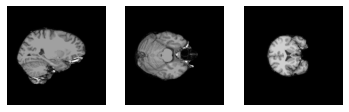

In [8]:
# Extract the brain slices:
brain = sub.images['brain']
slice0 = brain.dataobj[150,:,:]
slice1 = brain.dataobj[:,150,:]
slice2 = brain.dataobj[:,:,150]

(fig, axs) = plt.subplots(1, 3, figsize=(6, 2))

axs[0].imshow(slice0, cmap='gray')
axs[1].imshow(slice1, cmap='gray')
axs[2].imshow(slice2, cmap='gray')

for ax in axs:
    ax.axis('off')

The segmentation image looks quite a bit different because it stores labels that indicate the anatomical feature associated with each voxel.

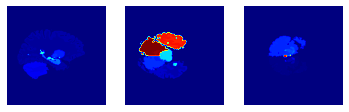

In [9]:
# Extract the brain slices:
brain = sub.images['segmentation']
slice0 = brain.dataobj[150,:,:]
slice1 = brain.dataobj[:,150,:]
slice2 = brain.dataobj[:,:,150]

(fig, axs) = plt.subplots(1, 3, figsize=(6, 2))

axs[0].imshow(slice0, cmap='jet')
axs[1].imshow(slice1, cmap='jet')
axs[2].imshow(slice2, cmap='jet')

for ax in axs:
    ax.axis('off')

### Cortices and Meshes

Neuropythy is especially good at managing data for the cortical surfaces that are constructed by FreeSurfer. These data are attached to `Cortex` objects, each of which represents a hemisphere. Although brains typically have two hemispheres (left and right), the data structure for storing hemispheres in neuropythy is a `dict`-like object because there is occasionally a need to represent more than two hemispheres. For example, in FreeSurfer, one can run the `surfreg` tool in order to create `lhx` and `rhx` hemispheres: mirror-reversed pseudo-hemispheres that can be aligned to the ipsilateral hemisphere; similarly, in the Human Connectome Project pipelines (which are also supported by neuropythy), there are not only the `lh` and `rh` native hemispheres, but the resampled `fs_LR` hemispheres.

For a typical FreeSurfer subject, however, the hemispheres are just the `'lh'` and `'rh'` hemispheres, which can be accessed either through the `sub.hemis` member variable or the `sub.lh` and `sub.rh` aliases.

In [10]:
# Each hemisphere has a certain number of faces (triangles) and 
# vertices (points).
(sub.lh, sub.rh)

(Cortex(<LH>, <266202 faces>, <133103 vertices>),
 Cortex(<RH>, <267634 faces>, <133819 vertices>))

In [11]:
# sub.lh is just an alias for sub.hemis['lh']; the same is true for
# the right hemisphere.
sub.lh is sub.hemis['lh']

True

The cortex object contains a wide variety of data related to the subject. First, we'll look at the structural organization of the cortex and the meshes that make up its surfaces, then we'll look at additional properties that are calculated by FreeSurfer and tracked by neuropythy.

#### FreeSurfer Cortex Geometry

A cortex/hemisphere has multiple "surfaces" including the white-matter surface (`'white'`), the pial surface (`'pial'`), the mid-gray surface (`'midgray'`), the inflated surface (`'inflated'`), and the spherical inflated surface (`'sphere'`). These surfaces are stored in the `sub.surfaces` and `sub.registrations` values, which are both `dict`-like lazy maps (registrations are special kinds of surfaces that have been fully inflated, such as the spherical surface or the fsaverage-aligned surface). However, it is generally suggested that one access the surfaces via the `cortex.surface(surf_name)` method (such as `cortex.surface('white')`). Additionally, some of the surfaces have aliases such as `cortex.white_surface` and `cortex.pial_surface`.

All surfaces of a single `Cortex` object share the same number of vertices and the same faces/triangles, meaning that if you have a set of data that maps onto the vertices of the cortex, it will be valid for any of the surfaces of that cortex. In other words, the individual surfaces of a cortex differ only in the position of their vertices (and in any data that are derived from these positions).

In [12]:
# Notice that the white and pial surfaces of the LH have the same
# number of faces and vertices.
(sub.lh.surface('white'), sub.lh.surface('pial'))

(Mesh(<3D>, <266202 faces>, <133103 vertices>),
 Mesh(<3D>, <266202 faces>, <133103 vertices>))

Surfaces are represented by `Mesh` objects. Meshes track a wide variety of data related to the cortical surface and its geometry. For example, one can extract the surface area of individual triangles on the surface mesh or its vertex normal vectors.

In [13]:
surf = sub.lh.surface('white')
# The face areas gives the surface area in square mm of each face/triangle.
surf.face_areas

array([0.05471953, 0.070954  , 0.13724601, ..., 0.01795164, 0.03093537,
       0.02908281])

In [14]:
# The vertex normals matrix is a 3 x N matrix of normal vectors at each
# vertex on the mesh.
surf.vertex_normals

array([[ 0.25689024,  0.01344057, -0.05691879, ...,  0.20805192,
         0.96850928,  0.87099722],
       [-0.93816271, -0.97783371, -0.99662903, ..., -0.63055431,
        -0.23229903, -0.2911042 ],
       [ 0.23207353,  0.20895116,  0.05908321, ..., -0.74774037,
        -0.08959313, -0.3957552 ]])

To see the coordinates themselves, we can look at `surf.coordinates`.

In [15]:
surf.coordinates

array([[ -13.12895203,  -13.58367443,  -13.86990738, ...,   -1.292328  ,
          -0.65406829,   -0.7429688 ],
       [-102.43490601, -102.45557404, -102.47897339, ...,   64.50788116,
          64.72080231,   64.82040405],
       [  -9.78337669,   -9.7538929 ,   -9.80977821, ...,   -6.64670658,
          -5.71247339,   -6.38333845]])

An important thing to realize about the cortices and surfaces is that, although the vertices are shared across surfaces, there is no particular ordering to the vertices on a surface/cortex. Two vertices that are near each other in the vertex list may not be near each other at all on the mesh. In order to see what vertices are linked to each other, we can look instead at the `surf.tess` object, which stores information about how the surface is tesselated: in other words, how triangles and vertices are connected and arranged on the mesh. This `tess` object is also shared with the `Cortex` object.

In [16]:
surf.tess

Tesselation(<266202 faces>, <133103 vertices>)

More information about the tesselation object and how it is connected to the surfaces and cortices can be found in the geometry tutorial.

#### FreeSurfer Cortex Properties

In addition to tracking the basic geometric information produced by FreeSurfer, neuropythy also tracks a number of properties of the cortical surface. These properties include things like the gray-matter thickness, the surface area of each individual vertex on the various surfaces, the curvature, and various parcellations of the surface.

Properties are identical across a single `Cortex` object and all of its surfaces. The interface is the same for both. We'll start by looking at a list of the available properties in a subject's hemisphere.

In [17]:
sorted(sub.lh.properties.keys())

['BA1_label',
 'BA1_weight',
 'BA2_label',
 'BA2_weight',
 'BA3a_label',
 'BA3a_weight',
 'BA3b_label',
 'BA3b_weight',
 'BA44_label',
 'BA44_weight',
 'BA45_label',
 'BA45_weight',
 'BA4a_label',
 'BA4a_weight',
 'BA4p_label',
 'BA4p_weight',
 'BA6_label',
 'BA6_weight',
 'DKT40_parcellation',
 'Desikan06_parcellation',
 'Destrieux09_parcellation',
 'MT_label',
 'MT_weight',
 'V1_label',
 'V1_weight',
 'V2_label',
 'V2_weight',
 'atlas_curvature',
 'brodmann_area',
 'brodmann_area_wide',
 'convexity',
 'cortex_label',
 'curvature',
 'entorhinal_label',
 'entorhinal_weight',
 'index',
 'jacobian_norm',
 'label',
 'midgray_surface_area',
 'parcellation',
 'perirhinal_label',
 'perirhinal_weight',
 'pial_curvature',
 'pial_surface_area',
 'surface_area',
 'thickness',
 'white_curvature',
 'white_surface_area']

There should be a rather large number of properties here (the number may be smaller or larger depending on what FreeSurfer subject you used for this tutorial). We'll now take a closer look at a few more common properties.

In general, the properties attached to a FreeSurfer subject's `Cortex` object can be found in the subjects `surf` and `label` directories. Properties that end in `_label` are typically boolean maps where `True` indicates that a vertex is part of a region of interest (for example the `'V1_label'` property indicates which vertices are in V1, according to FreeSurfer's anatomical alignment); similarly, properties that end in `_weight` are usually unrounded versions of the matching `_label` property. For example, if one rounds `'V1_weight'` to either 1 or 0 at each vertex, one should get a vector of boolean values that is identical to the `'V1_label'` property.

Other properties such as `'curvature'` and `'thickness'` give specific values such as the gray-matter thickness in mm (in the case of `'thickness'`).

In [18]:
# We can extract a property with the prop method or by directly pulling
# it from the properties dictionary.
(sub.lh.prop('curvature'),
 sub.lh.properties['curvature'])

(array([-0.2944349 , -0.28993565, -0.2842038 , ..., -0.4435404 ,
        -0.45679098, -0.5688864 ], dtype=float32),
 array([-0.2944349 , -0.28993565, -0.2842038 , ..., -0.4435404 ,
        -0.45679098, -0.5688864 ], dtype=float32))

Properties are typically vectors with one value per vertex. Any property attached to a given surface or cortex should always have the same number of rows as there are vertices in the associated object.

In [19]:
len(surf.prop('curvature')) == surf.vertex_count

True

If we want to see a property visualized on the cortical surface, we can plot the cortical surface using that property as the color. For more information on plotting, see the plotting tutorial.

In [20]:
# We'll plot the thickness property, with a minimum value
# (for the colormap) of 2 mm and a max of 6 mm.
ny.cortex_plot(surf, color='thickness', cmap='hot', vmin=2, vmax=6)

Figure(camera=PerspectiveCamera(fov=0.644570721372708, position=(0.0, -100.0, 0.0), projectionMatrix=(1.0, 0.0…